# Testing scripts for the DFXM simulator

## Introduction

References:
1. H. F. Poulsen, A. C. Jakobsen, H. Simons, S. R. Ahl, P. K. Cook, and C. Detlefs, X-Ray Diffraction Microscopy Based on Refractive Optics, J Appl Crystallogr 50, 1441 (2017).
2. H. F. Poulsen, L. E. Dresselhaus-Marais, M. A. Carlsen, C. Detlefs, and G. Winther, Geometrical-Optics Formalism to Model Contrast in Dark-Field X-Ray Microscopy, J Appl Crystallogr 54, 1555 (2021).

The code (Supplementary material of the Poulsen et al., 2021 paper) can be separated into three distinct parts:
* The resolution function (res_fxn_q)
* Displacement gradient of edge dislocation (edge_disl_helper)
* DFXM forward model (forward_model_setup)

We will test them separately in this notebook and write necessary notes to help the users to better understand how to use and modify the code.

## Displacement gradient of an edge dislocation

The function to calculate the displacement gradient of an edge dislocation is adapted from the section 8 of Poulsen et al. (2021).


The coordinate system for the edge dislocation in an fcc system is defined as following (Fig. 7 in Poulsen et al., 2021):

$$
\hat{x}_d=\vec{b}_s=1/2[1\bar{1}0]_s;\quad
\hat{y}_d=\vec{n}_s=[11\bar{1}]_s;\quad
\hat{z}_d=\vec{\xi}_s=[112]_s.
$$



Given the sample coordinate system is defined as:

$$
\hat{x}_s=[100];\quad
\hat{y}_s=[010];\quad
\hat{z}_s=[001].
$$

Therefore, the rotation matrix that converts a vector in the dislocation coordinates $\vec{r}_d$ into a vector in the sample (grain) coordinates $\vec{r}_g$ is,

$$
\vec{r}_g = \mathbf{U}_d\vec{r}_d
$$


where $\mathbf{U}_d$ is the rotation matrix that can be written as,

$$
\mathbf{U}_d = \left(
    \begin{matrix}
        b_{x,g}, n_{x,g}, \xi_{x,g}\\
        b_{y,g}, n_{y,g}, \xi_{y,g}\\
        b_{z,g}, n_{z,g}, \xi_{z,g}
    \end{matrix}
\right)
$$

In [1]:
import numpy as np
import edge_disl_helper as edge

be = [1, -1, 0]
ns = [1,1,-1]
xi = [1,1,2]

# Calculate the rotation matrix based on the normal and dislocation line directions (equation 65)
print('original Ud')
Ud = edge.return_dis_grain_matrices(b=be, n=ns, t=xi)
print(Ud)

# Compare with the original all matrices in the all 12 slip systems (transposed)
print('transposed Ud')
Udall = edge.return_dis_grain_matrices_all()
print(Udall[:, :, 3])

original Ud
[[ 0.70710678  0.57735027  0.40824829]
 [-0.70710678  0.57735027  0.40824829]
 [ 0.         -0.57735027  0.81649658]]
transposed Ud
[[ 0.70710678 -0.70710678  0.        ]
 [ 0.57735027  0.57735027 -0.57735027]
 [ 0.40824829  0.40824829  0.81649658]]


Here we derive the stress and strain field of a perfect edge dislocation in the dislocation coordinates. (Adapted from Cai and Nix, 2016, Section 9.1.3)

When an edge dislocation is created, the elastic field is a plane strain problem in the x-y plane (all the strain in the x-y plane). Plane strain problems are usually solved by finding the Airy stress function $\phi(x,y)$ that satisfies the _biharmonic equation_:

$$
\nabla^2(\nabla^2\phi(x,y))\equiv
\left(\frac{\partial^2}{\partial x^2}+\frac{\partial^2}{\partial y^2}\right)
\left(\frac{\partial^2}{\partial x^2}+\frac{\partial^2}{\partial y^2}\right)
\phi(x,y) = 0
$$

where the stresses can be obtained by the corresponding derivatives of the Airy stress function:

$$
\sigma_{xx}=\frac{\partial^2\phi}{\partial x^2};\quad
\sigma_{yy}=\frac{\partial^2\phi}{\partial y^2};\quad
\sigma_{xy}=-\frac{\partial^2\phi}{\partial x\partial y}
$$

*Note that harmonic functions must be biharmonic functions, but the inverse does not always apply.*

Write the $\nabla^2$ in the cylindrical polar coordinate (Section 2.5.3),

$$
\nabla^2\equiv
\left( \frac{\partial^2}{\partial r^2} +
       \frac{1}{r}\frac{\partial}{\partial r} +
       \frac{1}{r^2}\frac{\partial^2}{\partial\theta^2}
\right)
$$

and the stress fields in the cylindrical coordinates can be expressed in terms of the stress function as:

$$
\sigma_{rr} = \left(\frac{1}{r}\frac{\partial}{\partial r} +
       \frac{1}{r^2}\frac{\partial^2}{\partial\theta^2}
\right)\phi(r,\theta)
$$
$$
\sigma_{\theta\theta} = \frac{\partial^2}{\partial r^2}\phi(r,\theta)
$$
$$
\sigma_{r\theta} = -\frac{\partial}{\partial r}\left(
       \frac{1}{r}\frac{\partial}{\partial\theta}\phi(r,\theta)
\right)
$$

The general solution of the Airy stress function in the cylindrical coordinates can be written as,

$$
\phi(r, \theta) = f(r)\sin\theta,\quad
f(r)=Br^3-Ar\ln r
$$

where $B$ and $A$ are constants to be determined from the boundary conditions.

The stress functions are,

$$
\sigma_{rr}=\left(-\frac{A}{r}+2Br\right)\sin\theta
$$
$$
\sigma_{\theta\theta}=\left(-\frac{A}{r}+6Br\right)\sin\theta
$$
$$
\sigma_{r\theta}=\left(\frac{A}{r}-2Br\right)\cos\theta
$$

Considering the boundary condition $\sigma\rightarrow 0$ when $R\rightarrow\infty$, $B$ must be 0.

The strain field can be written as the gradient of the displacement field (eq 2.27),

$$
\varepsilon_{rr}=\frac{\partial u_r}{\partial r},\quad
\varepsilon_{\theta\theta}=
    \frac{1}{r}\frac{\partial u_\theta}{\partial\theta} + \frac{u_r}{r},\quad
\varepsilon_{zz}=\frac{\partial u_z}{\partial z}
$$
$$
\varepsilon_{r\theta}=\frac{1}{2}\left(
    \frac{\partial u_\theta}{\partial r} - \frac{u_\theta}{r} + 
    \frac{1}{r}\frac{\partial u_r}{\partial\theta}
\right)
$$
$$
\varepsilon_{rz}=\frac{1}{2}\left(
    \frac{\partial u_r}{\partial z} + \frac{\partial u_z}{\partial r} 
\right)
$$
$$
\varepsilon_{\theta z} = \frac{1}{2}\left(
    \frac{1}{r}\frac{\partial u_z}{\partial\theta} +
    \frac{\partial u_\theta}{\partial z}
\right)
$$

And the constitution relation (stress-strain relation) can be written as,

$$
\underline{\underline{\sigma}}=
\lambda\mathbf{Tr}(\underline{\underline{\varepsilon}}) +
2\mu\underline{\underline{\varepsilon}}
$$

where $\lambda$ and $\mu$ are Lam&eacute; constants.

According to the relations above, we can write the displacement solution of the edge dislocation as (Barber 2010),

$$
u_r^\infty = \frac{A}{\mu}(1-\nu)\theta\cos\theta -
    \frac{A}{2\mu}\sin\theta\left[
        (1-2\nu)\ln r-{1\over2}
    \right]
$$
$$
u_\theta^\infty =-\frac{A}{\mu}(1-\nu)\theta\sin\theta -
    \frac{A}{2\mu}\cos\theta\left[
        (1-2\nu)\ln r+{1\over2}
    \right]
$$

which can be written in the Cartesian coordinates as,

$$
u_x^\infty = \frac{A}{\mu}(1-\nu)\theta + \frac{A}{4\mu}\sin 2\theta
$$
$$
u_y^\infty = -\frac{A}{2\mu}(1-2\nu)\ln r-\frac{A}{4\mu}\cos 2\theta
$$

Since we expect $u_x$ to contain a $b\theta/(2\pi)$ term to account for the jump condition at the cut plane, we must select the constant $A$ as,

$$
A=\frac{\mu b}{2\pi(1-\nu)}
$$

Therefore, the full solution can be written as,

$$
\phi(x,y)=-\frac{\mu b}{2\pi(1-\nu)}\,y\ln\sqrt{x^2+y^2}
$$

and the corresponding displacement field is (eq 9.29),

$$
u_x = \frac{b}{2\pi}\left[
    \arctan\left({y\over x}\right)+\frac{1}{2(1-\nu)}\frac{xy}{x^2+y^2}
\right]
$$
$$
u_y = -\frac{b}{2\pi}\left[
    \frac{1-2\nu}{4(1-\nu)}\ln(x^2+y^2)+\frac{1}{4(1-\nu)}\frac{x^2-y^2}{x^2+y^2}
\right]
$$

which does not depend on the $\mu$, only the Poisson's ratio $\nu$.

The corresponding displacement gradient field can be written as (Poulsen et al., 2021, eq. 69),

$$
\mathbf{F}^d=\mathbf{I} + \left(\begin{matrix}
    \frac{\partial u_{d,x}}{\partial x} & \frac{\partial u_{d,x}}{\partial y} & 0 \\
    \frac{\partial u_{d,y}}{\partial x} & \frac{\partial u_{d,y}}{\partial y} & 0 \\
    0 & 0 & 0
\end{matrix}\right)
$$

where the non-zero components are (eq. 70-73),

$$
F_{xx}^d = 1 - \frac{by}{4\pi(1-\nu)}\left[
    \frac{3x^2 + y^2 - 2\nu(x^2+y^2)}{(x^2+y^2)^2}
\right]
$$
$$
F_{xy}^d = \frac{bx}{4\pi(1-\nu)}\left[
    \frac{3x^2 + y^2 - 2\nu(x^2+y^2)}{(x^2+y^2)^2}
\right]
$$
$$
F_{yx}^d = -\frac{bx}{4\pi(1-\nu)}\left[
    \frac{x^2 + 3y^2 - 2\nu(x^2+y^2)}{(x^2+y^2)^2}
\right]
$$
$$
F_{yy}^d = 1 + \frac{by}{4\pi(1-\nu)}\left[
    \frac{x^2 - y^2 - 2\nu(x^2+y^2)}{(x^2+y^2)^2}
\right]
$$
$$
F_{zz}^d = 1
$$

Now we visualize the displacement (deformation) gradient field (non-symmetric) for the edge dislocation for verification. Here are the conditions we use to showcase the field:

1. **Burger's vector $b=1$ (all length normalized with b)**
2. **Poisson's ratio $\nu=0.334$**

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

xd = np.linspace(-1, 1, 100)
yd = np.linspace(-1, 1, 100)
input_dict = {'b': 1, 'nu': 0.334}

XX, YY = np.meshgrid(xd, yd)
Fd = edge.get_disl_strain_tensor(input_dict, XX, YY) - np.identity(3)
print(Fd.shape)

(100, 100, 3, 3)


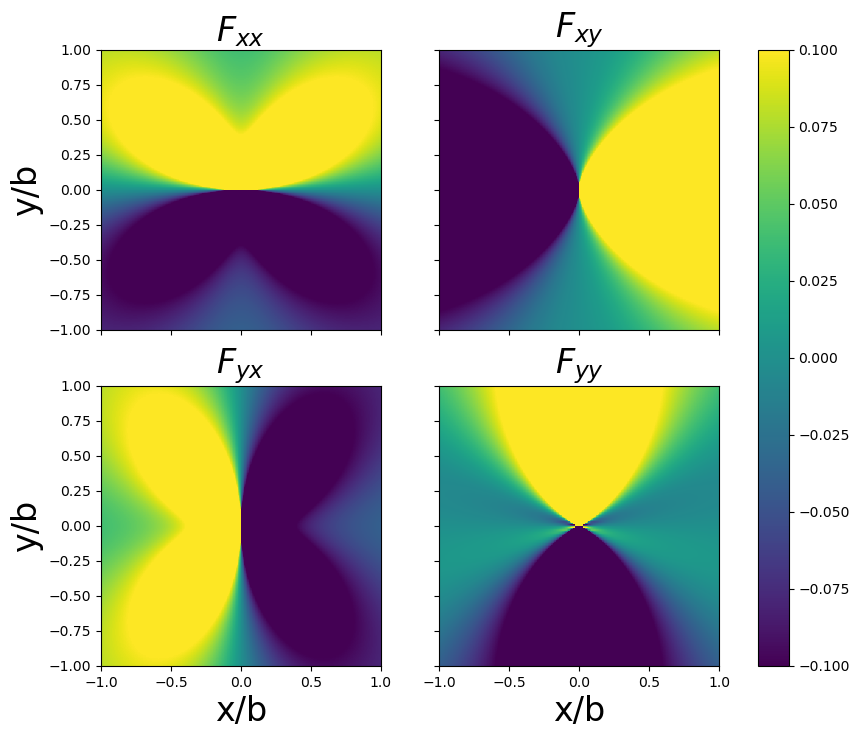

In [3]:
subs = ['x', 'y', 'z']
strain = (Fd + np.swapaxes(Fd, -1, -2))/2
fs = 24
fig, axs = plt.subplots(2,2, figsize=(10,8),sharex=True, sharey=True)
for i in range(2):
    for j in range(2):
        ax = axs[i][j]
        if i == j:
            vmin, vmax = 0, 2
        else:
            vmin, vmax = -1, 1
        vmin, vmax = -0.1, 0.1
        cim = ax.imshow(Fd[..., i,j], extent=[-1,1,-1,1], vmin=vmin, vmax=vmax)
        if i == 1:
            ax.set_xlabel('x/b', fontsize=fs)
        if j == 0:
            ax.set_ylabel('y/b', fontsize=fs)
        ax.set_title(r'$F_{%s%s}$'%(subs[i], subs[j]), fontsize=fs)

fig.colorbar(cim, ax=axs)
plt.show()

Then we calculate the strain field in the grain coordinates.

We assume the dislocation line is crossing the original point (0,0,0) in the grain coordinates. Here we calculate the strain field for a 3D voxelized space between (0, 1).

The geometry we use is the same as Fig.7 in the Poulsen et al., 2021 paper, where $b$, $n$, and $t$ are the Burger's vector, slip plane normal, and dislocation line direction, respectively.

![Edge dislocation geometry](edge_geometry.png)

In [4]:
# Define the voxelized 3D field

lb, ub = -1, 1
Ngrid = 50
offset = 1e-4                           # to avoid the singularity at the core
xg = np.linspace(lb, ub, Ngrid)-offset  # (Ngrid, )
yg = np.linspace(lb, ub, Ngrid)         # (Ngrid, )
zg = np.linspace(lb, ub, Ngrid)         # (Ngrid, )

XX, YY, ZZ = np.meshgrid(xg, yg, zg)    # (Ngrid, Ngrid, Ngrid)
RR = np.stack([XX,YY,ZZ], -1)           # (Ngrid, Ngrid, Ngird, 3)

# Rotate the vector
Rd = np.sum(np.linalg.inv(Ud)*RR[:,:,:,None,:], axis=-1)    # (Ngrid, Ngrid, Ngrid, 3)
Rdx = Rd[..., 0]
Rdy = Rd[..., 1]

print(Rdx.shape, Rdy.shape)

# Calculate the strain tensor
Fd = edge.get_disl_strain_tensor(input_dict, Rdx, Rdy)      # (Ngrid, Ngrid, Ngrid, 3, 3)

print(Fd.shape)

# Convert back to the grain coordinate
Fg = np.einsum('ij,...jk,kl->...il', Ud, Fd, Ud.T)         # (Ngrid, Ngrid, Ngrid, 3, 3)

print(Fg.shape)

(50, 50, 50) (50, 50, 50)
(50, 50, 50, 3, 3)
(50, 50, 50, 3, 3)


Here we visualize the rotated strain map for the pure edge dislocation.

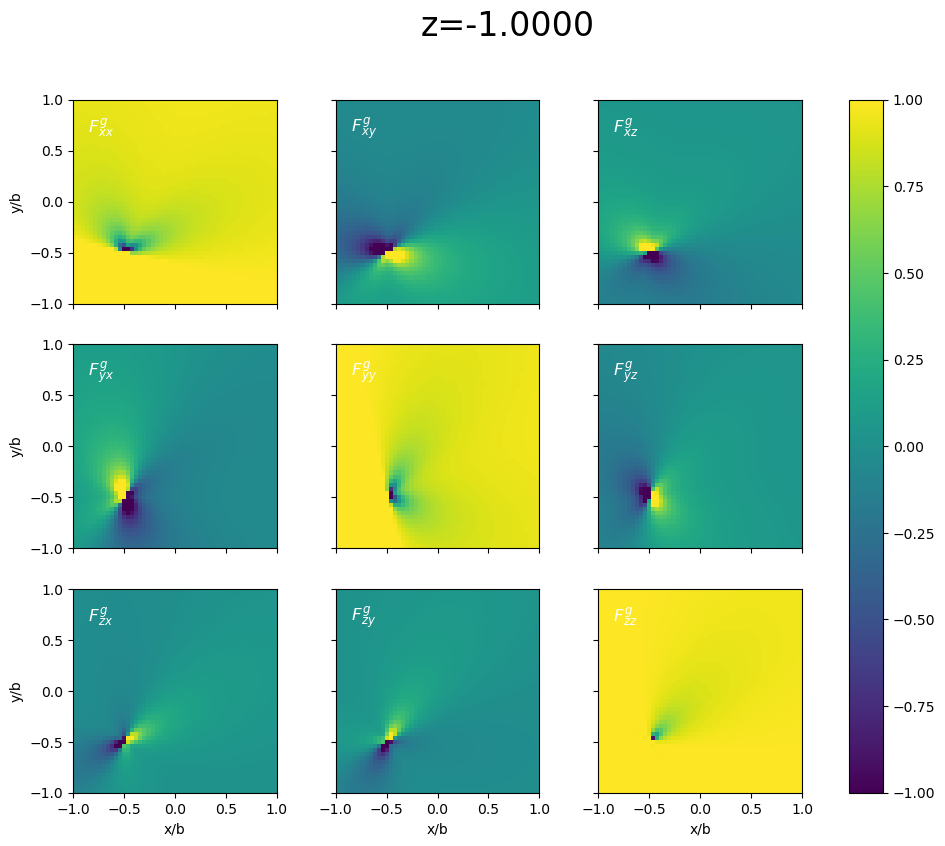

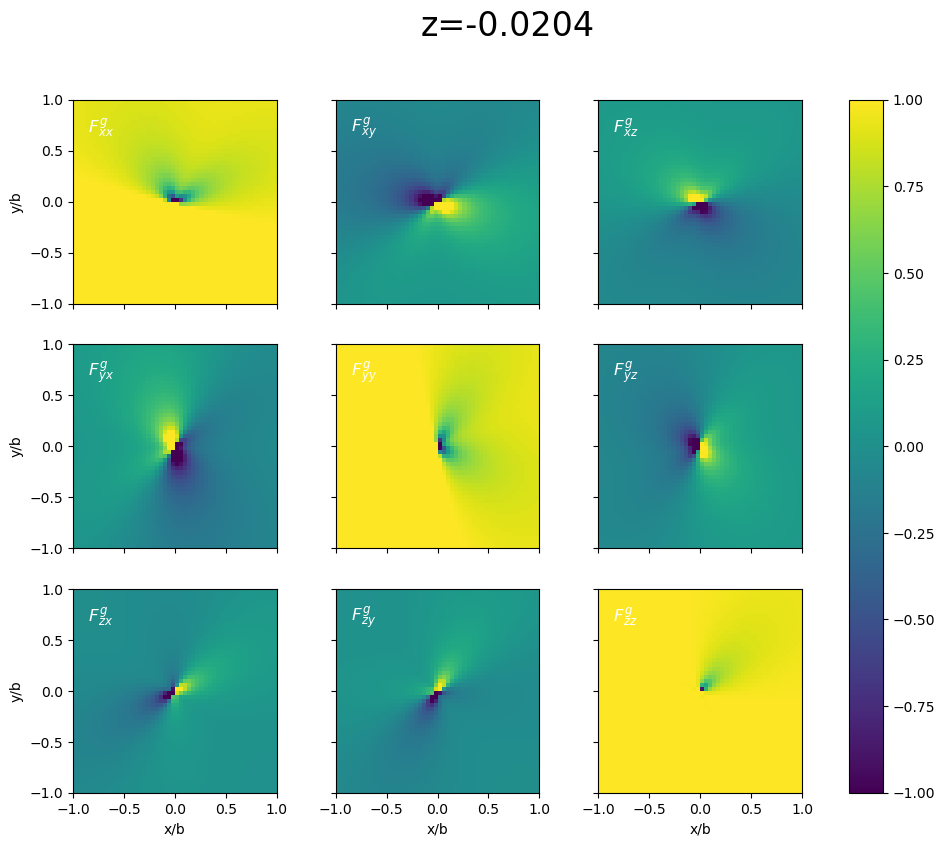

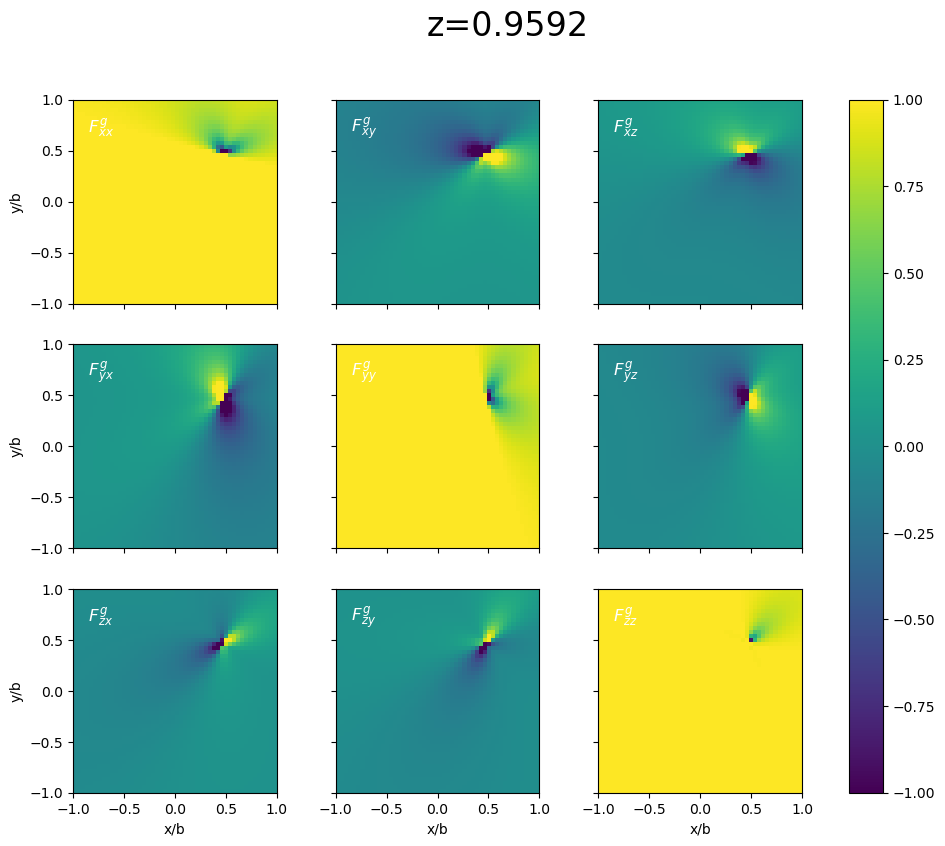

In [5]:
# Visualize the rotated strain map (x-y plane)

subs = ['x', 'y', 'z']
vmin, vmax = -1, 1

for iz in range(0, Ngrid, Ngrid//2-1):
    fig, axs = plt.subplots(3,3,figsize=(12,9), sharex=True, sharey=True)
    for i in range(3):
        for j in range(3):
            Fg_z = Fg[::-1, :, iz, i, j]
            ax = axs[i][j]
            im = ax.imshow(Fg_z, extent=[lb, ub, lb, ub], vmin=vmin, vmax=vmax)
            ax.set_title(r'   $F^g_{%s%s}$'%(subs[i], subs[j]), loc='left', y=0.8, color='w')
        axs[i][0].set_ylabel('y/b')
        axs[-1][i].set_xlabel('x/b')
    fig.colorbar(im, ax=axs)
    fig.suptitle('z=%.4f'%zg[iz], fontsize=24)
    plt.show()

Visualize the strain field with dislocation in 3D

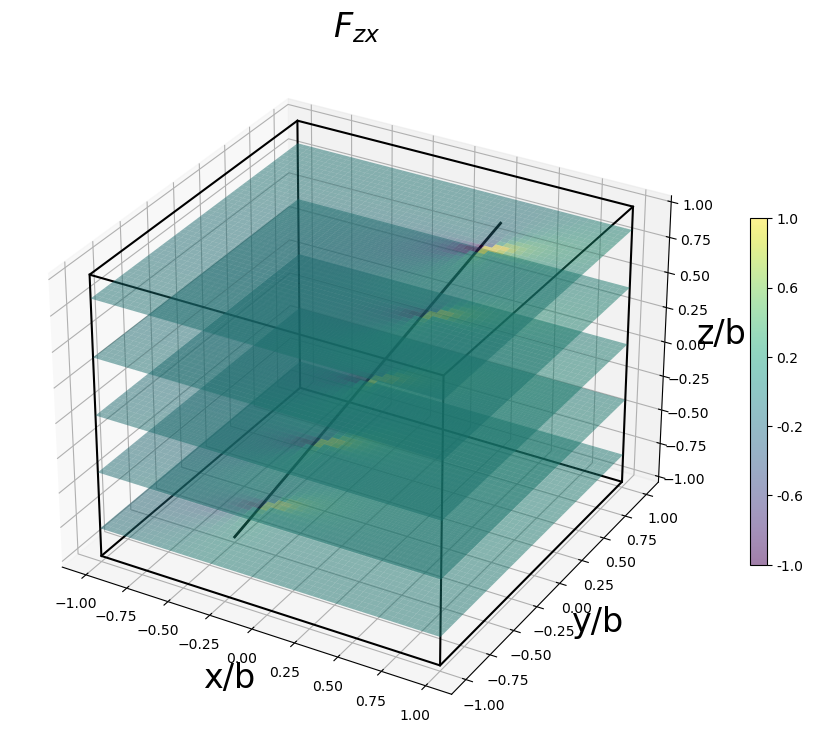

In [6]:
from matplotlib.colors import Normalize
subs = ['x', 'y', 'z']
xx, yy = np.meshgrid(xg, yg)
zz = (-ns[0] * xx - ns[1] * yy) / ns[2]
zz[zz>ub] = np.nan
zz[zz<lb] = np.nan
# yy, xx = np.meshgrid(yg, xg)
vmin, vmax = -1, 1

zt = np.linspace(lb, ub)
yt = zt/xi[2]*xi[1]
xt = zt/xi[2]*xi[0]
# tline = np.stack([xt, yt, zt])

for i in [2]:#range(3):
    for j in [0]:#range(3):
        fig = plt.figure(figsize=(12,9))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot([lb, lb, ub, ub], [ub, ub, ub, ub], [lb, ub, ub, lb], 'k')
        ax.plot([lb, lb, ub, ub], [lb, ub, ub, lb], [lb, lb, lb, lb], 'k')
        ax.plot(xt, yt, zt, 'k', linewidth=2)
        # ax.plot_surface(xx, yy, zz, color='r',linewidth=0, alpha=0.5)
        
        for iz in range(5, 50, 10):
            zloc = zg[iz]                  # z location of the plane
            Fg_z = Fg[:, :, iz, i, j]      # value of the plane
            zval = np.clip(Fg_z, vmin, vmax)
            norm = Normalize(vmin=vmin, vmax=vmax)
            surf = ax.plot_surface(xx, yy, np.ones_like(xx)*zloc, linewidth=0, edgecolor="None", facecolors=plt.cm.viridis(norm(zval)), alpha=0.5)
            
        cax = fig.colorbar(surf, shrink=0.5)
        cticks = cax.get_ticks()
        cax.set_ticks(cticks)
        cax.set_ticklabels(['%.1f'%(k*2-1) for k in cticks])
        ax.set_title('$F_{%s%s}$'%(subs[i], subs[j]), fontsize=24)

        ax.plot([lb, lb, ub, ub], [lb, lb, lb, lb], [ub, lb, lb, ub], 'k')
        ax.plot([lb, lb, ub, ub], [ub, lb, lb, ub], [ub, ub, ub, ub], 'k')
        ax.set_xlabel('x/b', fontsize=fs)
        ax.set_ylabel('y/b', fontsize=fs)
        ax.set_zlabel('z/b', fontsize=fs)
        plt.show()

## Reciprocal space resolution function

In this section, we calculate the resolution function in the reciprocal space and compare it with Henning's implementation.

The special parameters in Henning's implementation are:
* $\phi=-0.0004$
* `q1_range = 2e-3`
which leads to a cut-off of the resolution function.

Note that `rms` is the spread ($\sigma$) of the Gaussian, while `fwhm` is the full-width half maximum of the Gaussian. They correlate by a factor of `2.35`.

In [7]:
import numpy as np

res_dict = {
    'zeta_v_rms' : 0.53e-3/2.35,     # incoming divergence in vertical direction, in rad
    'zeta_h_rms': 1e-5/2.35,         # incoming divergence in horizontal direction, in rad 
    'NA_rms' : 7.31e-4/2.35,    # NA of objective, in rad
    'eps_rms' : 0.00006,        # rms width of x-ray energy bandwidth (2.355 factor fwhm -> rms)
    'zl_rms' : 0.6e-6/2.35, # rms width of the Gaussian beam profile, in m
    'two_theta' : 20.73,        # 2theta in degrees
    'D' : 2*np.sqrt(5e-5*1e-3), # physical aperture of objective, in m
    'd1' : 0.274,               # sample-objective distance, in m
    'TwoDeltaTheta' : 0,        # rotation of the 2 theta arm
    'phi' : -.000, #in rad; sample tilt angle 1
    'chi' : 0, #.015*np.pi/180, #in rad, sample tilt angle 2
    'hkl' : [0, 0, 2], # Miller indices for the diffraction plane
    'ns' : [1, 1, -1], # normal vector of the slip plane
    'bs' : [1, -1, 0], # Burgers vector of the slip system
    'ts' : [1, 1, 2],  # dislocation line direction
    'b' : 1, # 0.3057, # Burger's magnitude (unitless)
    'nu' : 0.334, # Poisson's ratio
    }
    
res_dict['mu'] = np.deg2rad(res_dict['two_theta'])      # in rad; base tilt
res_dict['theta'] = np.deg2rad(res_dict['two_theta']/2) # in rad
print('physical aperture (rad):', res_dict['D']/res_dict['d1'])

physical aperture (rad): 0.001632166406934153


Explanation to selected parameters:

* `physical aperture in rad (D/d1)` defines a "slit" between the sample and the detector (CRL objective lenses). Any ray outside of the slit will be filtered out, and won't get to the detector.
* `zl_rms` defines the "beam width" that scans "one slice" of the sample in the z-direction. The features outside of this range will not be seen (integrated) in the image.

Here we use the exact parameters as Henning's implementation to compare the resolution function result:

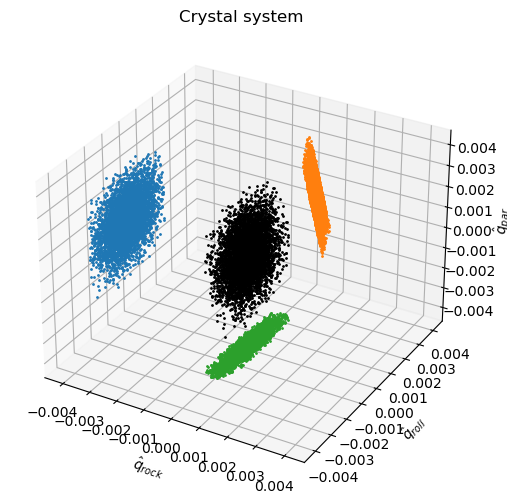

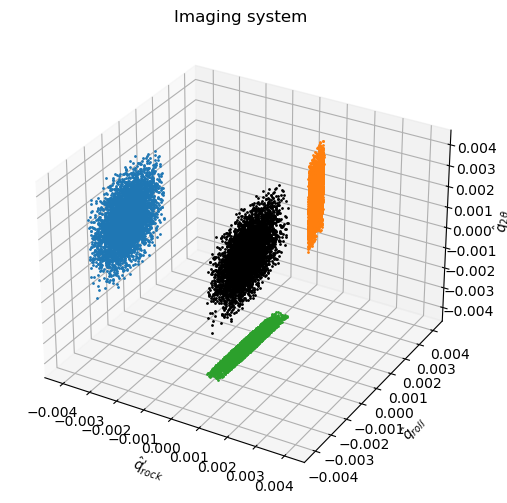

In [8]:
import forward_model_setup as fm
import time

# Henning's parameters
res_dict['phi'] = -0.0004
q1_range, npoints1 = 2e-3, 40
q2_range, npoints2 = 5e-3, 40
q3_range, npoints3 = 5e-3, 40

Res_qi_compare, outside = fm.res_fn(res_dict, q1_range=q1_range, q2_range=q2_range, q3_range=q3_range, npoints1=npoints1, npoints2=npoints2, npoints3=npoints3, Nrays=10000, plot=True)

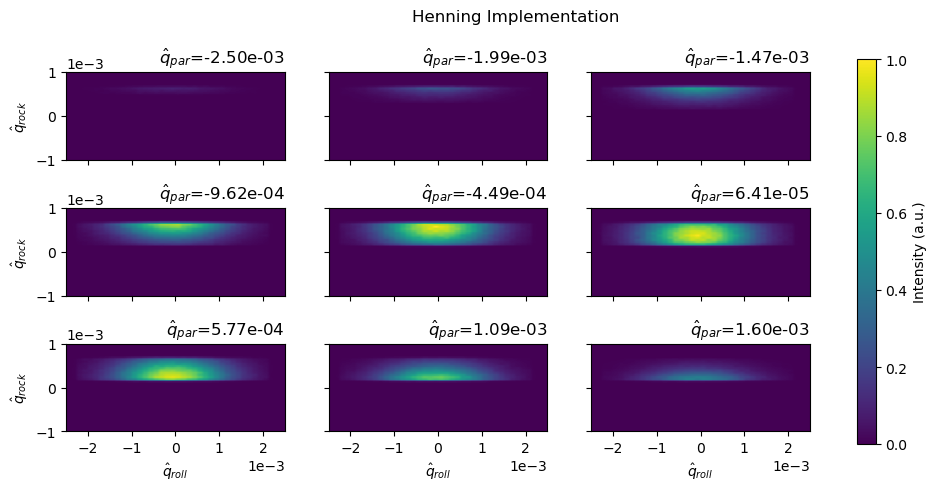

In [9]:
# Visualize slices of the resolution function
from scipy.io import loadmat
import matplotlib.pyplot as plt

Res_qi_ref = loadmat('Resq_i.mat')['Resq_i']

nskip = 4
fig, axs = plt.subplots(3, 3, figsize=(12,5), sharex=True, sharey=True)
q_extent = [-q2_range/2, q2_range/2, -q1_range/2, q1_range/2]
for iz in range(0, npoints3-4, nskip):
    zval = (iz/(npoints3-1)*2-1)*q3_range/2
    ind = iz//nskip
    ax = axs[ind//3, ind%3]
    imax = ax.imshow(Res_qi_ref[:,:,iz], extent=q_extent, vmin=0, vmax=1)
    ax.set_title(r'$\hat{q}_{par}$=%.2e'%zval, loc='right')
    if ind//3 == 2:
        ax.set_xlabel(r'$\hat{q}_{roll}$')
    if ind%3 == 0:
        ax.set_ylabel(r'$\hat{q}_{rock}$')
    ax.ticklabel_format(style='sci', scilimits=(0,0))
# create a shared colorbar on the right side for the henning implementation
cbar_ax = fig.colorbar(imax, ax=axs)
cbar_ax.set_label(r'Intensity (a.u.)')
fig.suptitle('Henning Implementation')
plt.show()

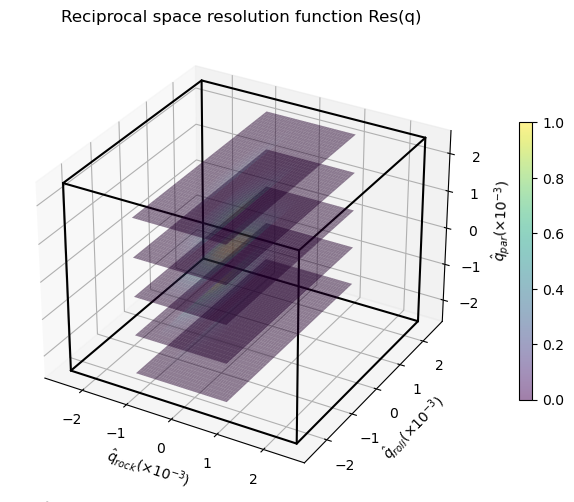

In [10]:
lb, ub = -2.5e-3, 2.5e-3
nskip = 8
fs = 14

x = q1_range/2*(np.arange(npoints1)/(npoints1-1)*2-1)
y = q2_range/2*(np.arange(npoints2)/(npoints2-1)*2-1)

yy,xx = np.meshgrid(y,x)

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot([lb, lb, ub, ub], [ub, ub, ub, ub], [lb, ub, ub, lb], 'k')
ax.plot([lb, lb, ub, ub], [lb, ub, ub, lb], [lb, lb, lb, lb], 'k')

for iz in range(4, npoints3, nskip):
    zloc = (iz/(npoints3-1)*2-1)*q3_range/2     # qpar location of the plane
    Fg_z = Res_qi_ref[:,:,iz]                   # values of the plane
    surf = ax.plot_surface(xx, yy, np.ones_like(xx)*zloc, linewidth=0, edgecolor="None", facecolors=plt.cm.viridis(Fg_z), alpha=0.5)
    
ax.plot([lb, lb, ub, ub], [lb, lb, lb, lb], [ub, lb, lb, ub], 'k')
ax.plot([lb, lb, ub, ub], [ub, lb, lb, ub], [ub, ub, ub, ub], 'k')
ax.set_ylabel(r'$\hat{q}_{roll}(\times10^{-3})$')#, fontsize=fs)
ax.set_xlabel(r'$\hat{q}_{rock}(\times10^{-3})$')#, fontsize=fs)
ax.set_zlabel(r'$\hat{q}_{par}(\times10^{-3})$')#, fontsize=fs)
ax.ticklabel_format(style='sci', scilimits=(0,0))
ax.set_title(r'Reciprocal space resolution function Res(q)')#, fontsize=fs)
cax = fig.colorbar(surf, shrink=0.6)

plt.show()

In [11]:
# Our parameters
res_dict['phi'] = -0.000
q1_range, npoints1 = 8e-3, 40
q2_range, npoints2 = 8e-3, 40
q3_range, npoints3 = 8e-3, 40

tic = time.time()
Res_qi, outside = fm.res_fn(res_dict, q1_range=q1_range, q2_range=q2_range, q3_range=q3_range, npoints1=npoints1, npoints2=npoints2, npoints3=npoints3, Nrays=10000000, plot=False)
toc = time.time()
print('Time elapsed: %.2f s'%(toc-tic))

# Save the resolution function to a file
np.savez_compressed('Res_qi', Res_qi=Res_qi)

Time elapsed: 20.90 s


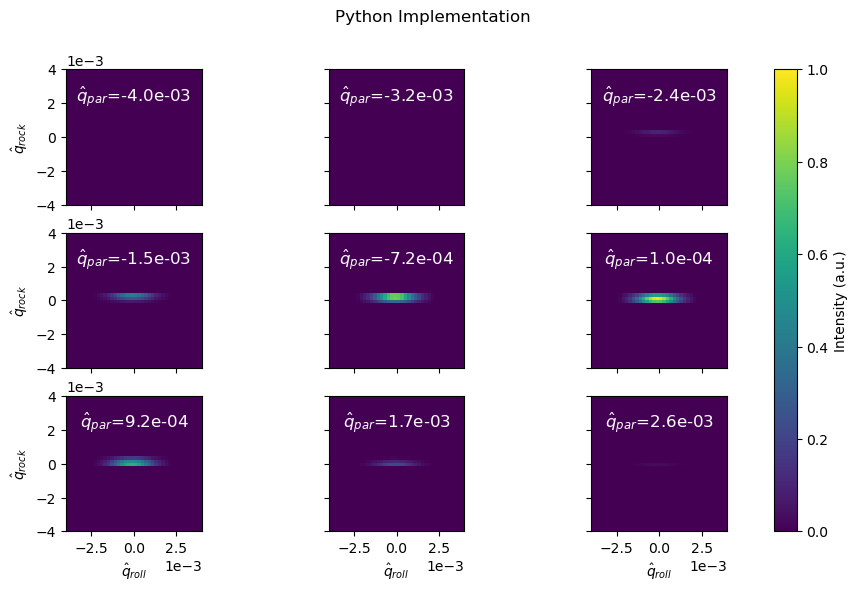

In [12]:
nskip = 4
fig, axs = plt.subplots(3, 3, figsize=(12,6), sharex=True, sharey=True)
q_extent = [-q2_range/2, q2_range/2, -q1_range/2, q1_range/2]
for iz in range(0, npoints3-4, nskip):
    zval = (iz/(npoints3-1)*2-1)*q3_range/2
    ind = iz//nskip
    ax = axs[ind//3, ind%3]
    imax = ax.imshow(Res_qi[:,:,iz], extent=q_extent, vmin=0, vmax=1)
    ax.set_title(r'$\hat{q}_{par}$=%.1e'%zval, y=0.7, color='w')
    if ind//3 == 2:
        ax.set_xlabel(r'$\hat{q}_{roll}$')
    if ind%3 == 0:
        ax.set_ylabel(r'$\hat{q}_{rock}$')
    ax.ticklabel_format(style='sci', scilimits=(0,0))
cbar_ax = fig.colorbar(imax, ax=axs)
cbar_ax.set_label(r'Intensity (a.u.)')
fig.suptitle('Python Implementation')
plt.show()

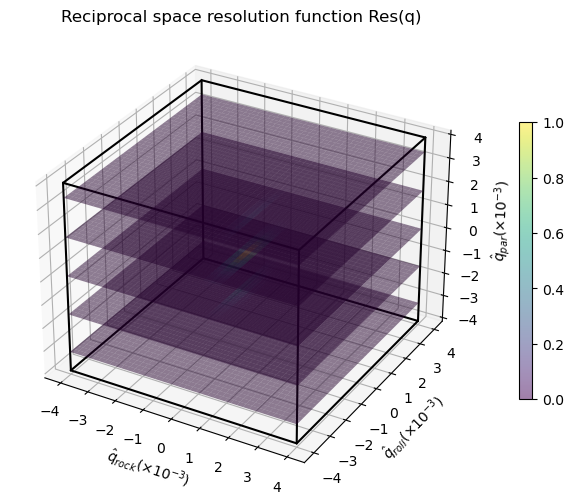

In [13]:
lb, ub = -4e-3, 4e-3
nskip = 8
fs = 14

x = q1_range/2*(np.arange(npoints1)/(npoints1-1)*2-1)
y = q2_range/2*(np.arange(npoints2)/(npoints2-1)*2-1)

yy,xx = np.meshgrid(y,x)

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot([lb, lb, ub, ub], [ub, ub, ub, ub], [lb, ub, ub, lb], 'k')
ax.plot([lb, lb, ub, ub], [lb, ub, ub, lb], [lb, lb, lb, lb], 'k')

for iz in range(4, npoints3, nskip):
    zloc = (iz/(npoints3-1)*2-1)*q3_range/2 # qpar location of the plane
    Fg_z = Res_qi[:,:,iz]                   # values of the plane
    surf = ax.plot_surface(xx, yy, np.ones_like(xx)*zloc, linewidth=0, edgecolor="None", facecolors=plt.cm.viridis(Fg_z), alpha=0.5)
    
ax.plot([lb, lb, ub, ub], [lb, lb, lb, lb], [ub, lb, lb, ub], 'k')
ax.plot([lb, lb, ub, ub], [ub, lb, lb, ub], [ub, ub, ub, ub], 'k')
ax.set_ylabel(r'$\hat{q}_{roll}(\times10^{-3})$')#, fontsize=fs)
ax.set_xlabel(r'$\hat{q}_{rock}(\times10^{-3})$')#, fontsize=fs)
ax.set_zlabel(r'$\hat{q}_{par}(\times10^{-3})$')#, fontsize=fs)
ax.ticklabel_format(style='sci', scilimits=(0,0))
ax.set_title(r'Reciprocal space resolution function Res(q)')#, fontsize=fs)
cax = fig.colorbar(surf, shrink=0.6)

plt.show()

## Test the forward model

We start with a simple case where there is only pure shear in a sphere in the sample, to test the forward model.

In [14]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt

import forward_model_setup as fm
import edge_disl_helper as edge
from visualize_helper import visualize_im_qi, visualize_res_fn_slice_z

# Set up the instrument parameters
forward_dict = {
    'psize' : 75e-9,            # pixel size, in m
    'zeta_v_rms' : 0.53e-3/2.35,     # incoming divergence in vertical direction, in rad
    'zeta_h_rms': 1e-5/2.35,         # incoming divergence in horizontal direction, in rad 
    'NA_rms' : 7.31e-4/2.35,    # NA of objective, in rad
    'eps_rms' : 0.00006,        # rms width of x-ray energy bandwidth (2.355 factor fwhm -> rms)
    # 'zl_rms' : 600/2.355, # rms width of the Gaussian beam profile
    'zl_rms' : 0.6e-6/2.35, # rms width of the Gaussian beam profile, in m
    'two_theta' : 20.73,        # 2theta in degrees
    'D' : 2*np.sqrt(5e-5*1e-3), # physical aperture of objective, in m
    'd1' : 0.274,               # sample-objective distance, in m
    'TwoDeltaTheta' : 0,        # rotation of the 2 theta arm
    'phi' : -.000, #in rad; sample tilt angle 1
    'chi' : 0, #.015*np.pi/180, #in rad, sample tilt angle 2
    'hkl' : [0, 0, 2], # Miller indices for the diffraction plane
    }
forward_dict['mu'] = np.deg2rad(forward_dict['two_theta'])      # in rad; base tilt
forward_dict['theta'] = np.deg2rad(forward_dict['two_theta']/2) # in rad

In [15]:
Res_qi = np.load('Res_qi.npz')['Res_qi']
im, ql, rulers = fm.forward(forward_dict, edge.Fg_test, Res_qi=Res_qi)

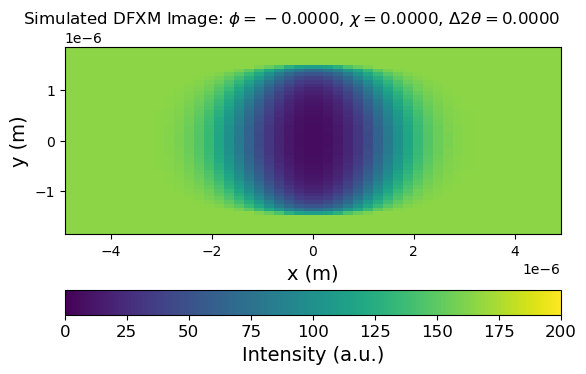

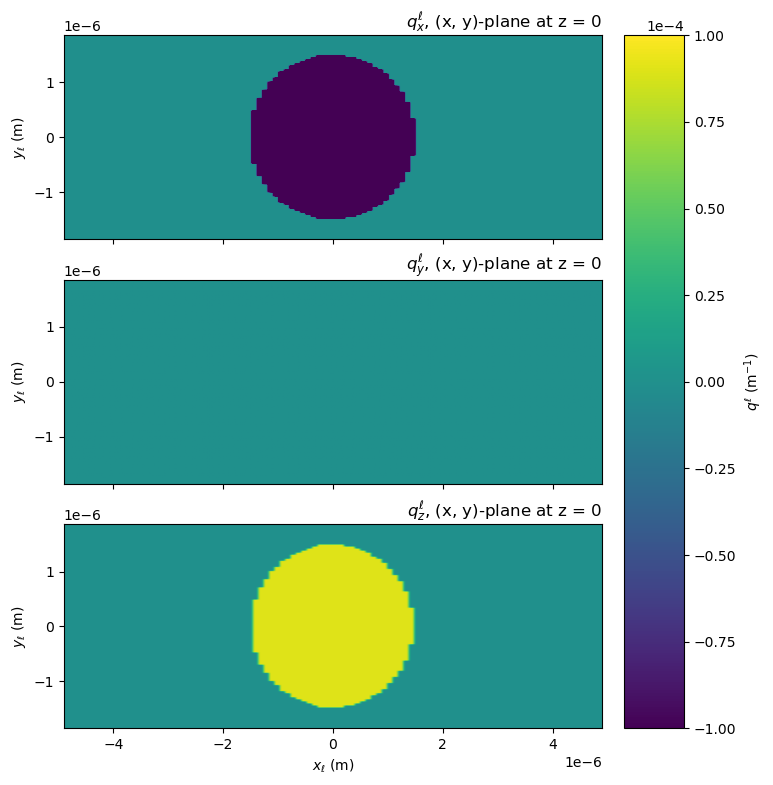

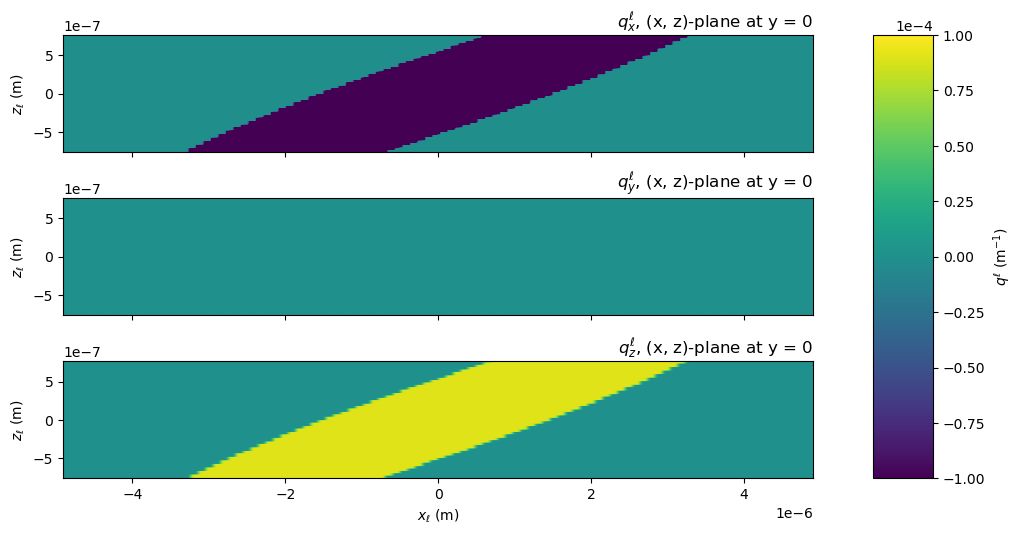

In [16]:
# Visualize the simulated image
figax = visualize_im_qi(forward_dict, im, None, rulers, vlim_im=[0, 200])

# Visualize the reciprocal space wave vector ql
figax = visualize_im_qi(forward_dict, None, ql, rulers, vlim_qi=[-1e-4, 1e-4])

Fg_zx
165.0339086415577 6.399639215884363


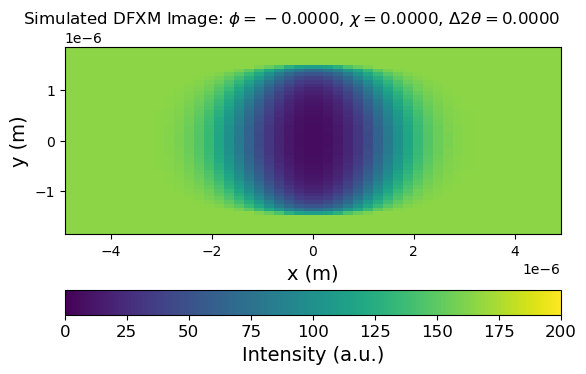

Fg_zy
165.0339086415577 86.12948244601003


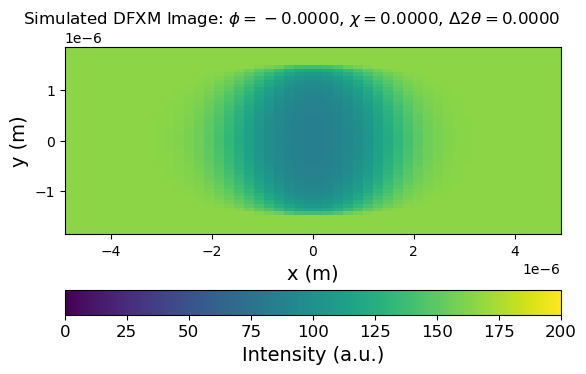

Fg_zz
165.0339086415577 107.64021318778968


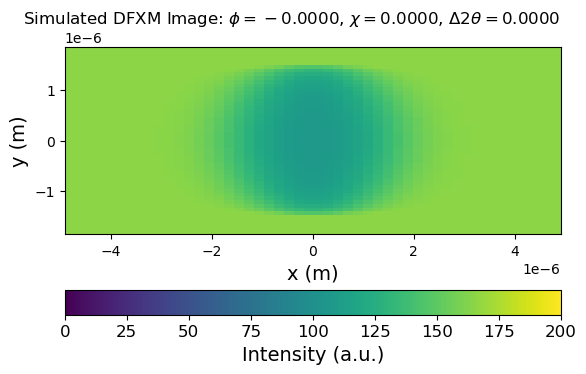

In [17]:
subs = ['x', 'y', 'z']
for i in [2]: #range(3):
    for j in range(3):
        print('Fg_%s%s'%(subs[i], subs[j]))
        Fg_func = lambda d, x, y, z: edge.Fg_test(d, x, y, z, components=(i, j), strain = 0.001)
        im, ql, rulers = fm.forward(forward_dict, Fg_func, Res_qi=Res_qi)
        # Visualize the simulated image
        print(im.max(), im.min())
        figax = visualize_im_qi(forward_dict, im, None, rulers, vlim_im=[0, 200])
       
        # Visualize the reciprocal space wave vector ql
        # visualize_im_qi(forward_dict, None, ql, rulers, vlim_qi=[-1e-4, 1e-4])


Now we test the DFXM forward model, which is implemented as function `forward` in the `forward_model_setup` module. Here we use the resolution function from Henning's implementation for benchmarking.

In [18]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt

import forward_model_setup as fm
import edge_disl_helper as edge
from visualize_helper import visualize_im_qi, visualize_res_fn_slice_z

forward_dict = {
    'psize' : 75e-9,            # pixel size, in m
    'zeta_v_rms' : 0.53e-3/2.35,     # incoming divergence in vertical direction, in rad
    'zeta_h_rms': 1e-5/2.35,         # incoming divergence in horizontal direction, in rad 
    'NA_rms' : 7.31e-4/2.35,    # NA of objective, in rad
    'eps_rms' : 0.00006,        # rms width of x-ray energy bandwidth (2.355 factor fwhm -> rms)
    # 'zl_rms' : 600/2.355, # rms width of the Gaussian beam profile
    'zl_rms' : 0.6e-6/2.35, # rms width of the Gaussian beam profile, in m
    'two_theta' : 20.73,        # 2theta in degrees
    'D' : 2*np.sqrt(5e-5*1e-3), # physical aperture of objective, in m
    'd1' : 0.274,               # sample-objective distance, in m
    'TwoDeltaTheta' : 0,        # rotation of the 2 theta arm
    'phi' : -.000, #in rad; sample tilt angle 1
    'chi' : 0, #.015*np.pi/180, #in rad, sample tilt angle 2
    'hkl' : [0, 0, 2], # Miller indices for the diffraction plane
    'ns' : [1, 1, -1], # normal vector of the slip plane
    'bs' : [1, -1, 0], # Burgers vector of the slip system
    'ts' : [1, 1, 2],  # dislocation line direction
    'b' : -2.86e-10, # 0.3057, # Burger's magnitude (unitless)
    'nu' : 0.3, # Poisson's ratio
    }

forward_dict['mu'] = np.deg2rad(forward_dict['two_theta'])      # in rad; base tilt
forward_dict['theta'] = np.deg2rad(forward_dict['two_theta']/2) # in rad
Res_qi = loadmat('Resq_i.mat')['Resq_i']
im, ql, rulers = fm.forward(forward_dict, edge.Fg_disl, Res_qi=Res_qi)

Here we visualize the simulated image `im` for the pure edge dislocation and the corresponding reciprocal space wave vector `ql` (in the lab coordinate system).

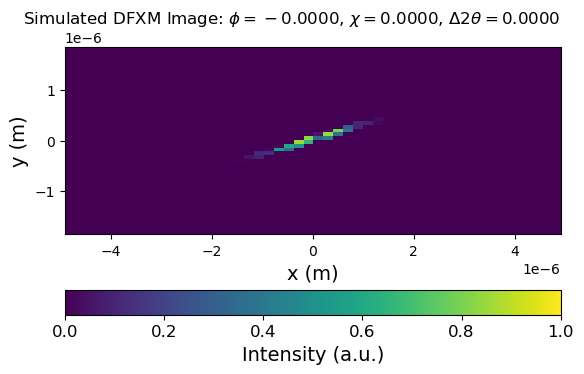

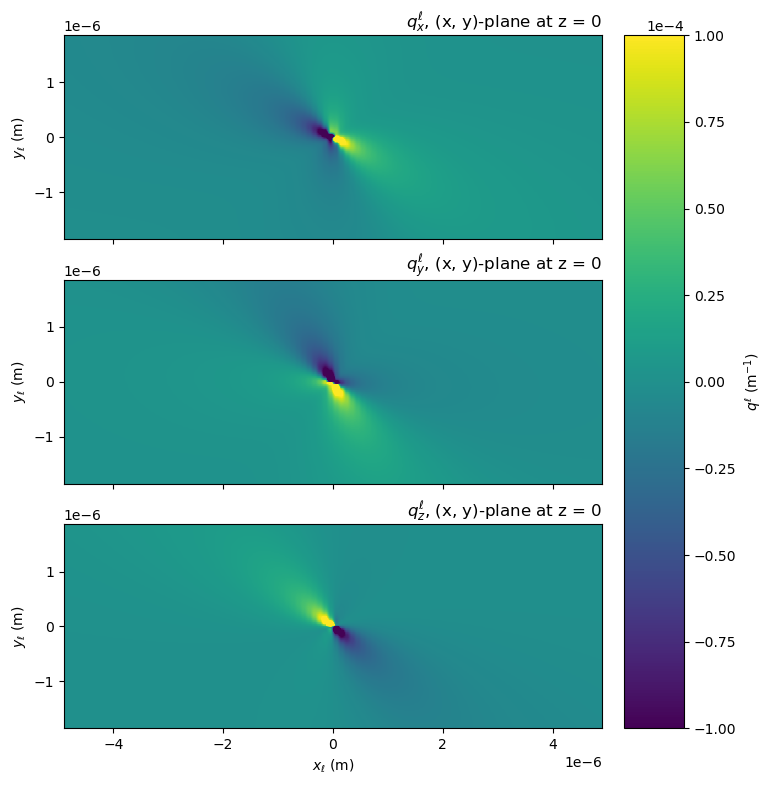

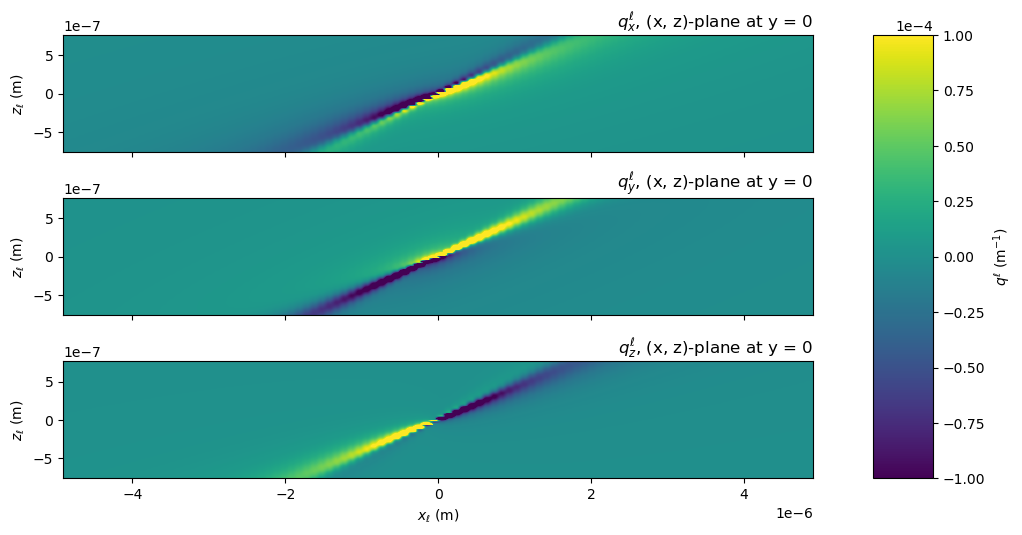

In [19]:
# Visualize the simulated image
figax = visualize_im_qi(forward_dict, im, None, rulers, vlim_im=[0, 1])

# Visualize the reciprocal space wave vector ql in the (x,y,z=0) plane
# Visualize the reciprocal space wave vector ql in the (x,y=0,z) plane
figax = visualize_im_qi(forward_dict, None, ql, rulers, vlim_qi=[-1e-4, 1e-4])

Now we use the resolution function calculated in-place (using the same pixel size with both the forward and resolution function).

In [20]:
import time

for i in range(3):
    res_dict['q%d_range'%(i+1)] = 8e-3
    res_dict['npoints%d'%(i+1)] = 40

tic = time.time()
im, qi, rulers = fm.forward(forward_dict, edge.Fg_disl)
toc = time.time()
print('time of the forward model (including resolution function): %.2fs'%(toc-tic))

time of the forward model (including resolution function): 21.39s


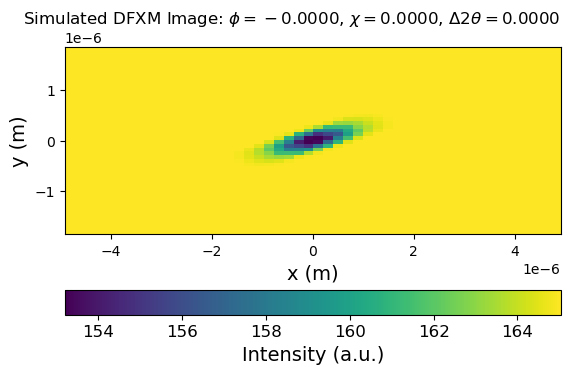

In [21]:
figax = visualize_im_qi(forward_dict, im, None, rulers, vlim_im=[None, None])

# Sweep the parameters to observe the results

## Resolution function

In [22]:
import os
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt

import forward_model_setup as fm
import edge_disl_helper as edge
from visualize_helper import visualize_im_qi, visualize_res_fn_slice_z

qrange = 0.032 # 8e-3
ngrids = 200 # 40

forward_dict = {
    'psize' : 75e-9,            # pixel size, in m
    'zeta_v_rms' : 0.53e-3/2.35,     # incoming divergence in vertical direction, in rad
    'zeta_h_rms': 1e-5/2.35,         # incoming divergence in horizontal direction, in rad 
    'NA_rms' : 7.31e-4/2.35,    # NA of objective, in rad
    'eps_rms' : 0.00006,        # rms width of x-ray energy bandwidth (2.355 factor fwhm -> rms)
    # 'zl_rms' : 600/2.355, # rms width of the Gaussian beam profile
    'zl_rms' : 0.6e-6/2.35, # rms width of the Gaussian beam profile, in m
    'two_theta' : 20.73,        # 2theta in degrees in [002]
    #'two_theta' : 29.64,        # 2theta in degrees in [2-20]
    'D' : 2*np.sqrt(5e-5*1e-3), # physical aperture of objective, in m
    'd1' : 0.274,               # sample-objective distance, in m
    'TwoDeltaTheta' : 0,        # rotation of the 2 theta arm
    'phi' : -.000, #in rad; sample tilt angle 1
    'chi' : 0, #.015*np.pi/180, #in rad, sample tilt angle 2
    'omega' : 0,
    'hkl' : [0, 0, 2], # Miller indices for the diffraction plane (this is zlab for the crystal orientation)
    'xlab': [-2, -2, 0], # Crystal orientation of the x direction in the lab system assuming lab and grain are the same
    'ylab': [2, -2, 0], #Crystal orientation of the y direction in the lab system assuming lab and grain are the same
    'ns' : [1, 1, -1], # normal vector of the slip plane
    'bs' : [1, -1, 0], # Burgers vector of the slip system
    'ts' : [1, 1, 2],  # dislocation line direction
    'b' : -2.86e-10, # 0.3057, # Burger's magnitude (unitless)
    'nu' : 0.3, # Poisson's ratio
    # Parameters for resolution function calculation
    'Nrays': 10000000,
    'q1_range': qrange, 'q2_range': qrange, 'q3_range': qrange, 
    'npoints1': ngrids, 'npoints2': ngrids, 'npoints3': ngrids
    }

forward_dict['mu'] = np.deg2rad(forward_dict['two_theta'])      # in rad; base tilt
forward_dict['theta'] = np.deg2rad(forward_dict['two_theta']/2) # in rad

Time for sampling rays: 9.68 s
Time for computing q: 10.49 s
Time for Monte Carlo ray tracing: 11.55 s
Time for voxelizing: 11.93 s


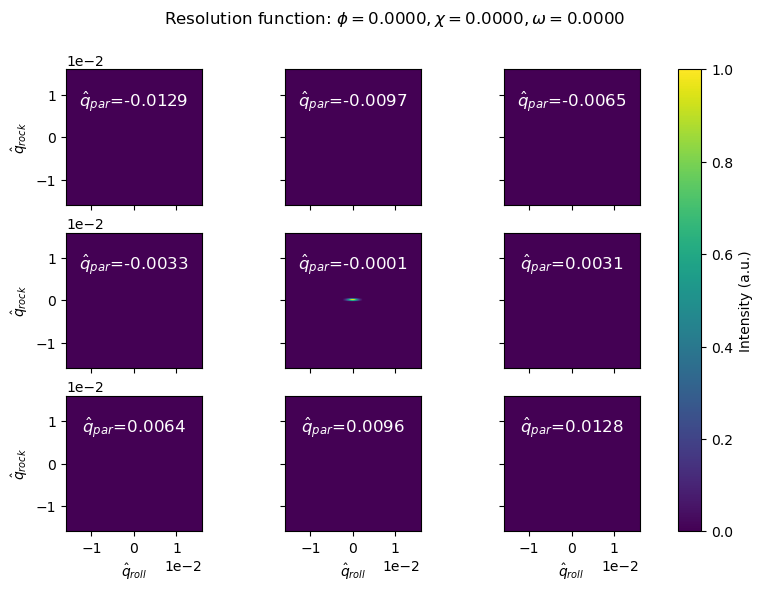

In [23]:
# Calculate and save resolution functions

rocking_qvals = np.linspace(-qrange, qrange, ngrids + 1)
# for phi_rocking in rocking_qvals:
#     forward_dict['phi'] = phi_rocking
#     Res_qi = fm.res_fn(forward_dict)

forward_dict['phi'] = 0
Res_qi_0, saved_q = fm.res_fn(forward_dict, Nrays=10000000, timeit=True)
qrock_prime, qroll, q2theta = saved_q
np.savez('Res_qi_0.npz', Res_qi=Res_qi_0, qrock_prime=qrock_prime, qroll=qroll, q2theta=q2theta)
# Res_qi_0 = np.load('Res_qi_0.npz')['Res_qi']
figax2d, _ = visualize_res_fn_slice_z(forward_dict, Res_qi_0, plot_3d=False)

Create a resolution function with $\phi=0.002$ and $\chi=0.0015$.

Time for computing q: 0.00 s
Time for Monte Carlo ray tracing: 1.02 s
Time for voxelizing: 1.36 s


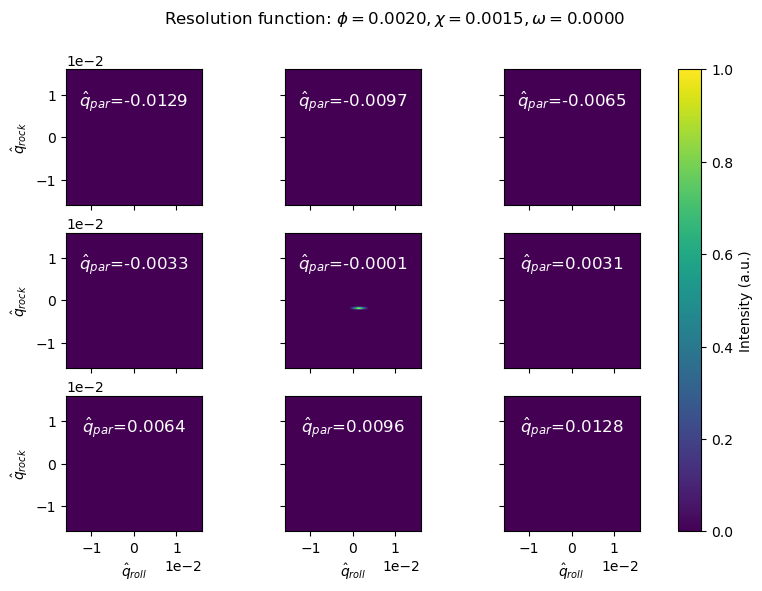

In [24]:
qrock_prime = np.load('Res_qi_0.npz')['qrock_prime']
qroll = np.load('Res_qi_0.npz')['qroll']
q2theta = np.load('Res_qi_0.npz')['q2theta']
saved_q = (qrock_prime, qroll, q2theta)

forward_dict['phi'] = 0.002
forward_dict['chi'] = 0.0015
Res_qi, _ = fm.res_fn(forward_dict, Nrays=10000000, saved_q=saved_q, timeit=True)
figax2d, figax3d = visualize_res_fn_slice_z(forward_dict, Res_qi, plot_3d=False)

# fig, axs = figax2d
# print(axs[0,0].get_xlim())
# axs[0,0].set_xlim(-0.006, 0.006)
# visualize_res_fn_slice_z(forward_dict, np.abs(Res_qi_1-Res_qi_0), plot_3d=False)

# im, ql, rulers = fm.forward(forward_dict, edge.Fg_disl, Res_qi=Res_qi)

# Rocking curve

Calculating resolution function for phi=-0.0030, chi=-0.0030
Initialization time: 0.01s
Calculate the wave vectors: 6.97s
Image calculation: 7.06s
phi=-0.0030, chi=-0.0030, max=0.0000, min=0.0000
Calculating resolution function for phi=-0.0030, chi=-0.0010
Initialization time: 0.01s
Calculate the wave vectors: 6.95s
Image calculation: 7.05s
phi=-0.0030, chi=-0.0010, max=0.1043, min=0.0000
Calculating resolution function for phi=-0.0030, chi=0.0010
Initialization time: 0.02s
Calculate the wave vectors: 7.87s
Image calculation: 8.00s
phi=-0.0030, chi=0.0010, max=0.0207, min=0.0000
Calculating resolution function for phi=-0.0030, chi=0.0030
Initialization time: 0.01s
Calculate the wave vectors: 6.82s
Image calculation: 6.94s
phi=-0.0030, chi=0.0030, max=0.0000, min=0.0000


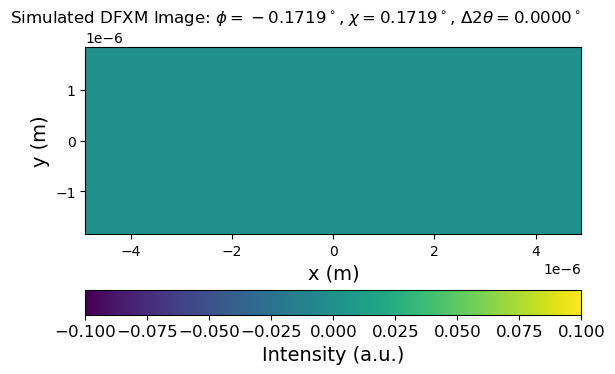

Calculating resolution function for phi=-0.0010, chi=-0.0030
Initialization time: 0.02s
Calculate the wave vectors: 6.98s
Image calculation: 7.09s
phi=-0.0010, chi=-0.0030, max=0.0077, min=0.0000
Calculating resolution function for phi=-0.0010, chi=-0.0010
Initialization time: 0.01s
Calculate the wave vectors: 6.79s
Image calculation: 6.89s
phi=-0.0010, chi=-0.0010, max=0.4347, min=0.0000
Calculating resolution function for phi=-0.0010, chi=0.0010
Initialization time: 0.00s
Calculate the wave vectors: 7.33s
Image calculation: 7.45s
phi=-0.0010, chi=0.0010, max=0.4835, min=0.0000
Calculating resolution function for phi=-0.0010, chi=0.0030
Initialization time: 0.01s
Calculate the wave vectors: 8.17s
Image calculation: 8.27s
phi=-0.0010, chi=0.0030, max=0.0054, min=0.0000
Calculating resolution function for phi=0.0010, chi=-0.0030
Initialization time: 0.01s
Calculate the wave vectors: 9.36s
Image calculation: 9.50s
phi=0.0010, chi=-0.0030, max=0.0053, min=0.0000
Calculating resolution fun

In [25]:
# phi_values = np.round(np.arange(-0.0040, 0.0042, 0.0004), 4)
# phi_values = np.round(np.linspace(-0.005, 0.005, 26), 4)
# chi_values = np.round(np.linspace(-0.005, 0.005, 26), 4)
phi_values = np.round(np.linspace(-0.003, 0.003, 4), 4)
chi_values = np.round(np.linspace(-0.003, 0.003, 4), 4)
# phi_values = np.round(np.linspace(-0.005, 0.005, 101), 4)
# chi_values = np.array([np.deg2rad(0.015), ])
# phi_values = [0]
os.makedirs('Res_files', exist_ok=True)
# chi = forward_dict['chi'] = np.deg2rad(0.015)

# rocking_maxvals = []
# rocking_minvals = []
rocking_maxvals = np.zeros((phi_values.size, chi_values.size))
rocking_minvals = np.zeros((phi_values.size, chi_values.size))

Res_qi_file = 'Res_qi_0.npz'
Res_qi = np.load(Res_qi_file)['Res_qi']

for i, phi in enumerate(phi_values):
    for j, chi in enumerate(chi_values):
        Res_qi_file = 'Res_files/Res_qi_phi%.4f_chi%.4f.npz'%(phi, chi)
        forward_dict['phi'] = phi
        forward_dict['chi'] = chi
        if not os.path.exists(Res_qi_file):
            print('Calculating resolution function for phi=%.4f, chi=%.4f'%(phi, chi))
            im, ql, rulers = fm.forward(forward_dict, edge.Fg_disl, Res_qi=Res_qi, timeit=True)
            # Res_qi, _ = fm.res_fn(forward_dict, Nrays=10000000, plot=False, saved_q=saved_q, timeit=True)
            np.savez_compressed(Res_qi_file, Res_qi=Res_qi, im=im, ql=ql, rulers=rulers)
        else:
            # Res_qi = np.load(Res_qi_file)['Res_qi']
            loaddata = np.load(Res_qi_file)
            im, ql, rulers = loaddata['im'], loaddata['ql'], loaddata['rulers']

        # rocking_maxvals.append(np.max(im))
        # rocking_minvals.append(np.min(im))
        rocking_maxvals[i, j] = np.max(im)
        rocking_minvals[i, j] = np.min(im)
        print('phi=%.4f, chi=%.4f, max=%.4f, min=%.4f'%(phi, chi,  rocking_maxvals[i, j], rocking_minvals[i, j]))
    if (i+0)%10 == 0:
        visualize_im_qi(forward_dict, im, None, rulers, vlim_im=[0, None], deg=True)

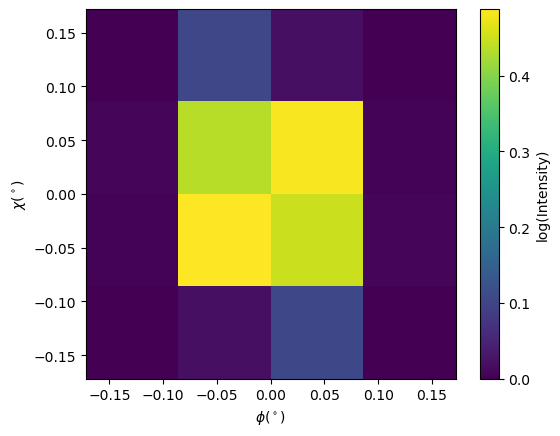

In [26]:
fig, ax = plt.subplots()
x1, x2 = np.rad2deg(phi_values.min()), np.rad2deg(phi_values.max())
y1, y2 = np.rad2deg(chi_values.min()), np.rad2deg(chi_values.max())
#imax = ax.imshow(np.log(rocking_maxvals), extent=[x1, x2, y1, y2])#log version gives white for 0
imax = ax.imshow(rocking_maxvals, extent=[x1, x2, y1, y2])
cax = fig.colorbar(imax)
ax.set_xlabel(r'$\phi(^\circ)$')
ax.set_ylabel(r'$\chi(^\circ)$')
cax.set_label('log(Intensity)')
plt.show()

Strong Beam Simulated Image

Calculating resolution function for phi=0.0000, chi=0.0000
Initialization time: 0.01s
Calculate the wave vectors: 6.80s
Image calculation: 6.89s


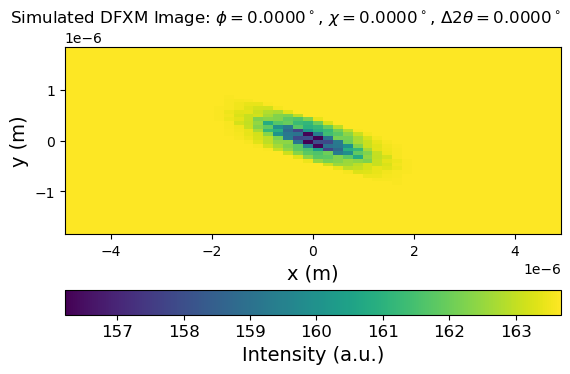

(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'right': 'Simulated DFXM Image: $\\phi = 0.0000^\\circ$, $\\chi = 0.0000^\\circ$, $\\Delta 2\\theta = 0.0000^\\circ$'}, xlabel='x (m)', ylabel='y (m)'>,
 None,
 None,
 None,
 None)

In [27]:
phi = chi = 0
Res_qi_file = 'Res_files/Res_qi_phi%.4f_chi%.4f.npz'%(phi, chi)
forward_dict['phi'] = phi
forward_dict['chi'] = chi
if not os.path.exists(Res_qi_file):
    print('Calculating resolution function for phi=%.4f, chi=%.4f'%(phi, chi))
    im, ql, rulers = fm.forward(forward_dict, edge.Fg_disl, Res_qi=Res_qi, timeit=True)
    # Res_qi, _ = fm.res_fn(forward_dict, Nrays=10000000, plot=False, saved_q=saved_q, timeit=True)
    np.savez_compressed(Res_qi_file, Res_qi=Res_qi, im=im, ql=ql, rulers=rulers)
else:
    # Res_qi = np.load(Res_qi_file)['Res_qi']
    loaddata = np.load(Res_qi_file)
    im, ql, rulers = loaddata['im'], loaddata['ql'], loaddata['rulers']
visualize_im_qi(forward_dict, im, None, rulers, vlim_im=[None, None], deg=True)

Calculating resolution function for phi=0.0008, chi=-0.0008
Initialization time: 0.01s
Calculate the wave vectors: 7.73s
Image calculation: 7.82s


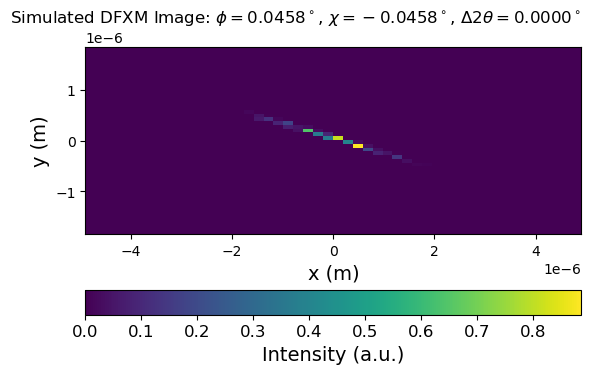

(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'right': 'Simulated DFXM Image: $\\phi = 0.0458^\\circ$, $\\chi = -0.0458^\\circ$, $\\Delta 2\\theta = 0.0000^\\circ$'}, xlabel='x (m)', ylabel='y (m)'>,
 None,
 None,
 None,
 None)

In [28]:
phi=0.0008
chi=-0.0008
Res_qi_file = 'Res_files/Res_qi_phi%.4f_chi%.4f.npz'%(phi, chi)
forward_dict['phi'] = phi
forward_dict['chi'] = chi
if not os.path.exists(Res_qi_file):
    print('Calculating resolution function for phi=%.4f, chi=%.4f'%(phi, chi))
    im, ql, rulers = fm.forward(forward_dict, edge.Fg_disl, Res_qi=Res_qi, timeit=True)
    # Res_qi, _ = fm.res_fn(forward_dict, Nrays=10000000, plot=False, saved_q=saved_q, timeit=True)
    np.savez_compressed(Res_qi_file, Res_qi=Res_qi, im=im, ql=ql, rulers=rulers)
else:
    # Res_qi = np.load(Res_qi_file)['Res_qi']
    loaddata = np.load(Res_qi_file)
    im, ql, rulers = loaddata['im'], loaddata['ql'], loaddata['rulers']
visualize_im_qi(forward_dict, im, None, rulers, vlim_im=[0, None], deg=True)

Weak Beam Simulated Image

Calculating resolution function for phi=-0.0006, chi=0.0006
Initialization time: 0.01s
Calculate the wave vectors: 7.02s
Image calculation: 7.12s


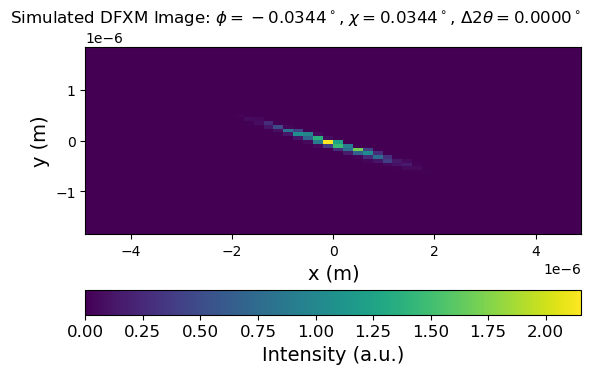

(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'right': 'Simulated DFXM Image: $\\phi = -0.0344^\\circ$, $\\chi = 0.0344^\\circ$, $\\Delta 2\\theta = 0.0000^\\circ$'}, xlabel='x (m)', ylabel='y (m)'>,
 None,
 None,
 None,
 None)

In [29]:
phi=-0.0006
chi=0.0006
Res_qi_file = 'Res_files/Res_qi_phi%.4f_chi%.4f.npz'%(phi, chi)
forward_dict['phi'] = phi
forward_dict['chi'] = chi
if not os.path.exists(Res_qi_file):
    print('Calculating resolution function for phi=%.4f, chi=%.4f'%(phi, chi))
    im, ql, rulers = fm.forward(forward_dict, edge.Fg_disl, Res_qi=Res_qi, timeit=True)
    # Res_qi, _ = fm.res_fn(forward_dict, Nrays=10000000, plot=False, saved_q=saved_q, timeit=True)
    np.savez_compressed(Res_qi_file, Res_qi=Res_qi, im=im, ql=ql, rulers=rulers)
else:
    # Res_qi = np.load(Res_qi_file)['Res_qi']
    loaddata = np.load(Res_qi_file)
    im, ql, rulers = loaddata['im'], loaddata['ql'], loaddata['rulers']
visualize_im_qi(forward_dict, im, None, rulers, vlim_im=[None, None], deg=True)

Calculating resolution function for phi=-0.0020, chi=0.0020


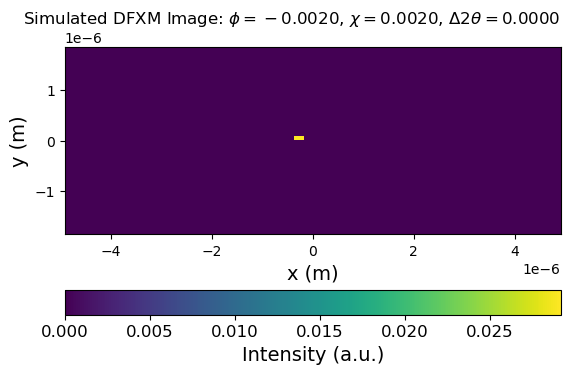

0.029160782531150408 0.0
Calculating resolution function for phi=-0.0018, chi=0.0020


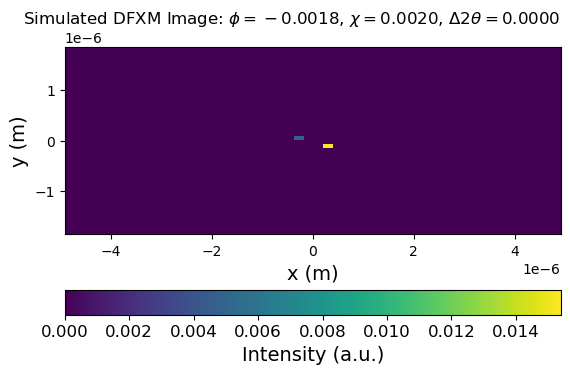

0.015393424235774573 0.0
Calculating resolution function for phi=-0.0016, chi=0.0020


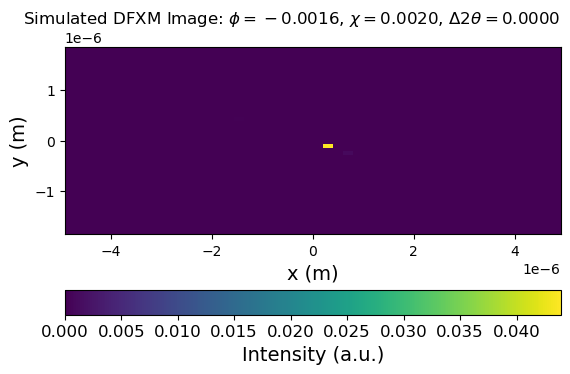

0.04390378039076551 0.0
Calculating resolution function for phi=-0.0014, chi=0.0020


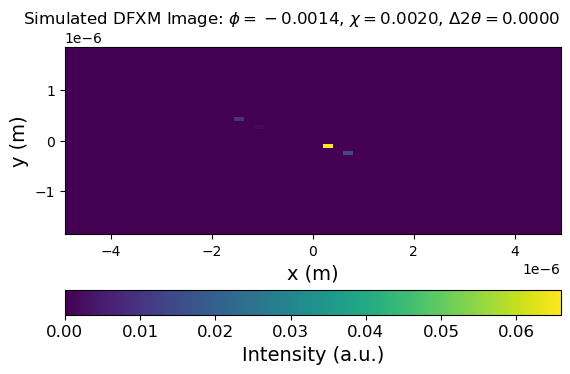

0.06590987278416155 0.0
Calculating resolution function for phi=-0.0012, chi=0.0020


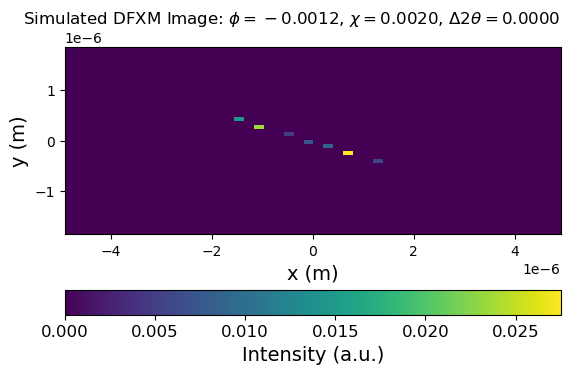

0.027504217708982485 0.0
Calculating resolution function for phi=-0.0010, chi=0.0020


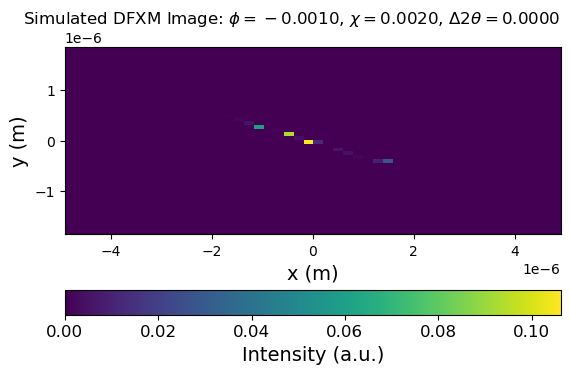

0.10622602696302265 0.0
Calculating resolution function for phi=-0.0008, chi=0.0020


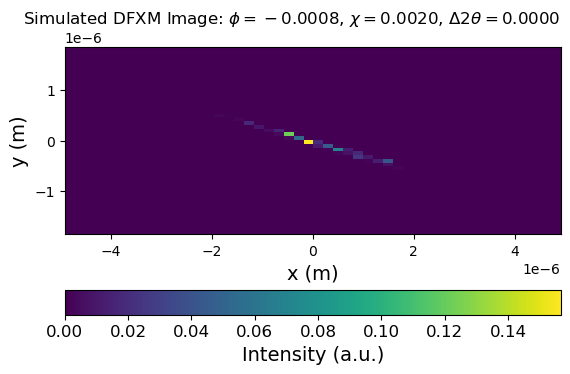

0.15665724777050888 0.0
Calculating resolution function for phi=-0.0006, chi=0.0020


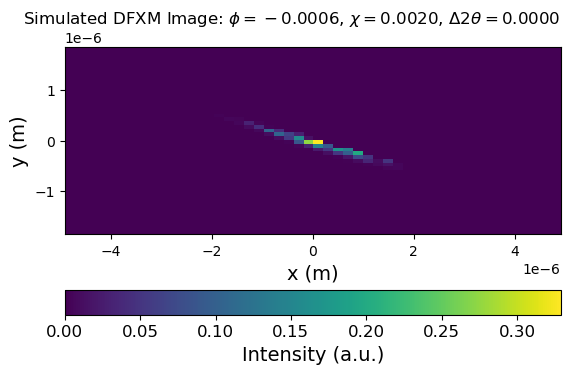

0.32900128995521993 0.0
Calculating resolution function for phi=-0.0004, chi=0.0020


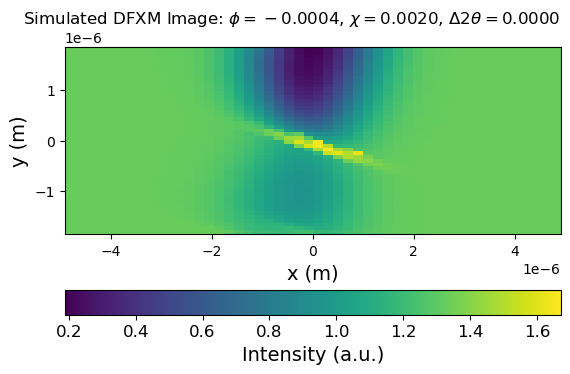

1.6714960016074478 0.18778232909308684
Calculating resolution function for phi=-0.0002, chi=0.0020


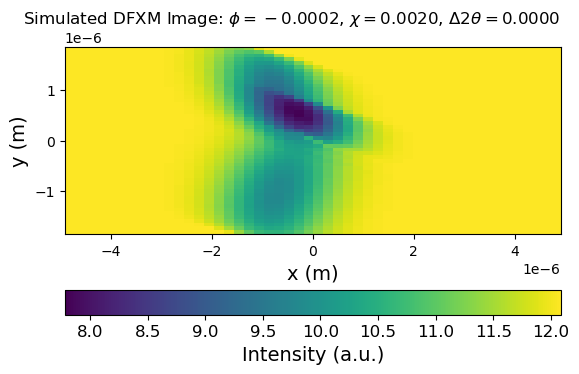

12.08673453815713 7.780428069672203
Calculating resolution function for phi=0.0000, chi=0.0020


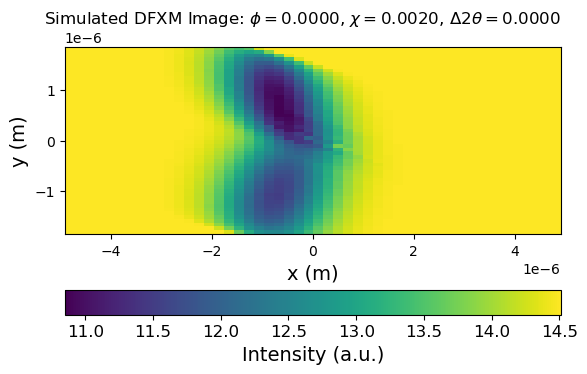

14.510068935741442 10.848601532260163
Calculating resolution function for phi=0.0002, chi=0.0020


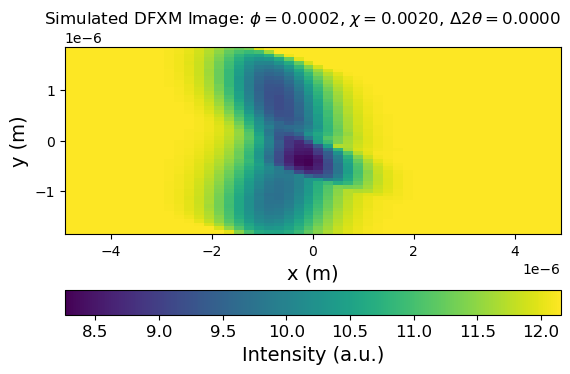

12.154390723186985 8.259116249387679
Calculating resolution function for phi=0.0004, chi=0.0020


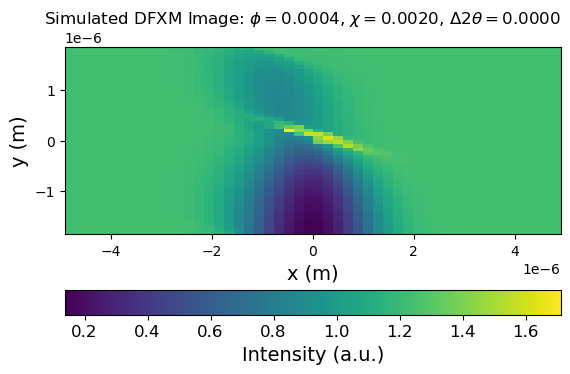

1.711923982492122 0.1372624685454387
Calculating resolution function for phi=0.0006, chi=0.0020


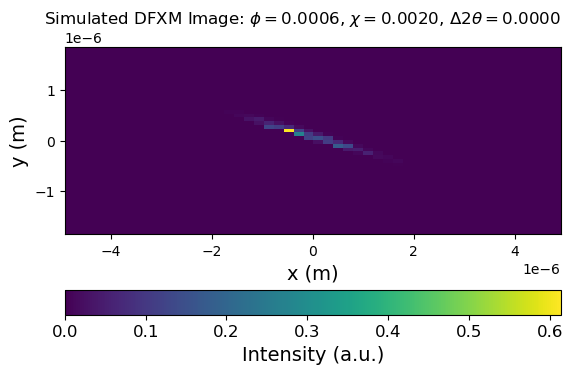

0.613459462442107 0.0
Calculating resolution function for phi=0.0008, chi=0.0020


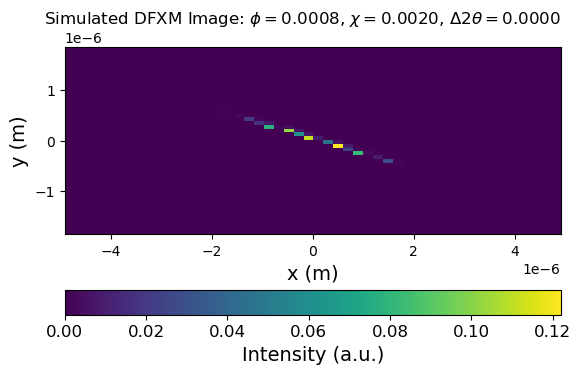

0.12196987846245415 0.0
Calculating resolution function for phi=0.0010, chi=0.0020


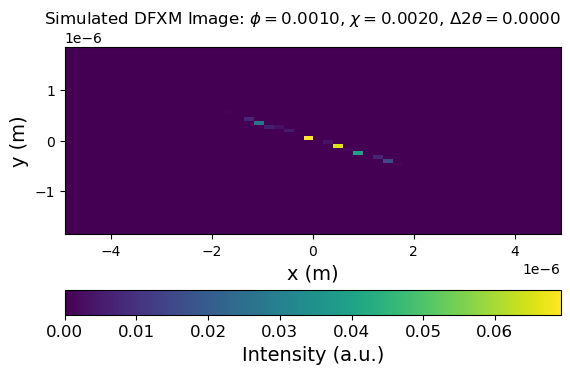

0.06918400218459356 0.0
Calculating resolution function for phi=0.0012, chi=0.0020


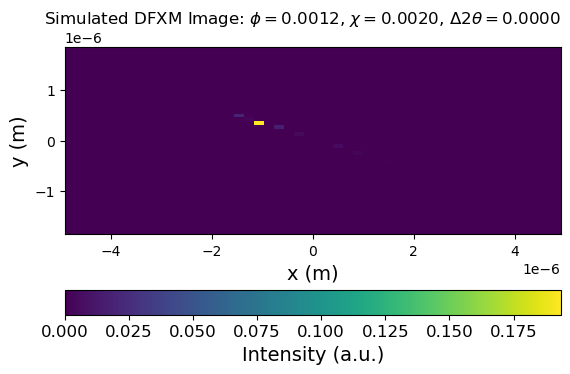

0.19341154806870628 0.0
Calculating resolution function for phi=0.0014, chi=0.0020


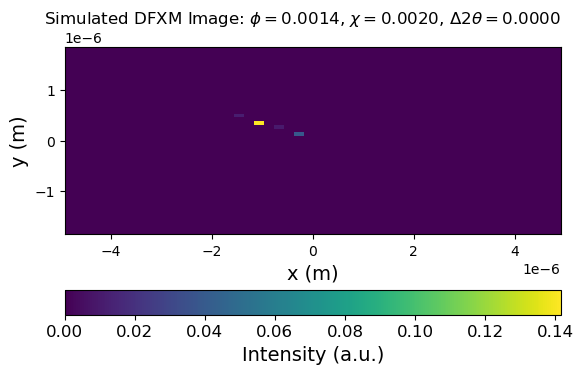

0.14161896768419996 0.0
Calculating resolution function for phi=0.0016, chi=0.0020


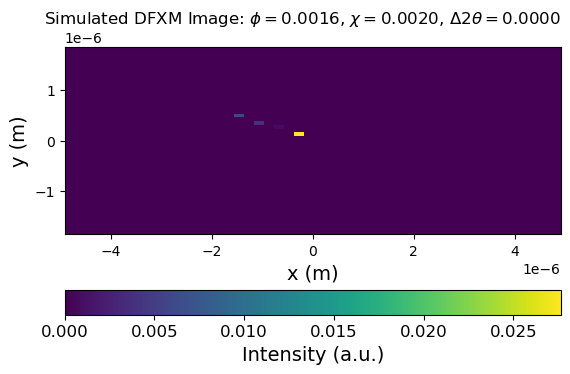

0.02764312098677827 0.0
Calculating resolution function for phi=0.0018, chi=0.0020


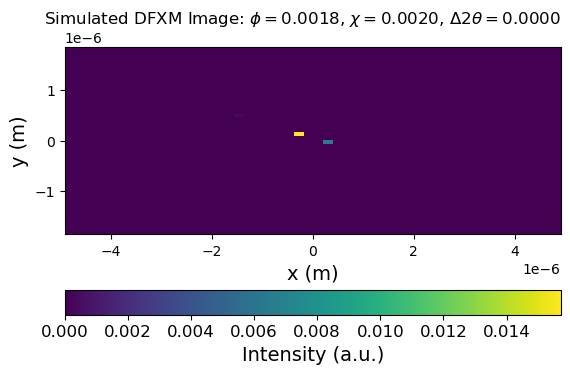

0.01571863742385431 0.0
Calculating resolution function for phi=0.0020, chi=0.0020


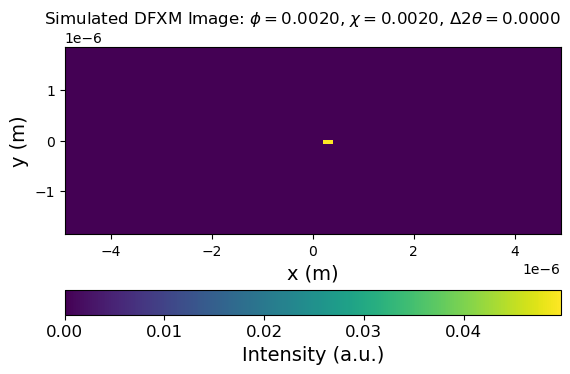

0.049757617776200906 0.0
Calculating resolution function for phi=0.0022, chi=0.0020


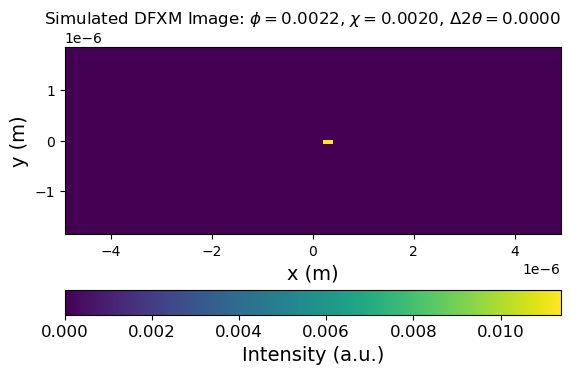

0.011382461582791057 0.0


In [30]:
phi_values = np.round(np.arange(-0.0020, 0.0022, 0.0002), 4)
os.makedirs('Res_files', exist_ok=True)
chi = forward_dict['chi'] = 0.0020

rocking_maxvals = []
rocking_ptpvals = []

Res_qi = np.load('Res_qi_0.npz')['Res_qi']

for phi in phi_values:
    Res_qi_file = 'Res_files/Res_qi_phi%.4f_chi%.4f.npz'%(phi, chi)
    print('Calculating resolution function for phi=%.4f, chi=%.4f'%(phi, chi))
    forward_dict['phi'] = phi
    # if not os.path.exists(Res_qi_file):
    #     Res_qi, _ = fm.res_fn(forward_dict, Nrays=10000000, plot=False, saved_q=saved_q, timeit=True)
    #     np.savez_compressed(Res_qi_file, Res_qi=Res_qi)
    # else:
    #     Res_qi = np.load(Res_qi_file)['Res_qi']

    im, ql, rulers = fm.forward(forward_dict, edge.Fg_disl, Res_qi=Res_qi)
    rocking_maxvals.append(np.max(im))
    rocking_ptpvals.append(np.max(im)-np.min(im))
    visualize_im_qi(forward_dict, im, None, rulers, vlim_im=[None, None])
    print(im.max(), im.min())

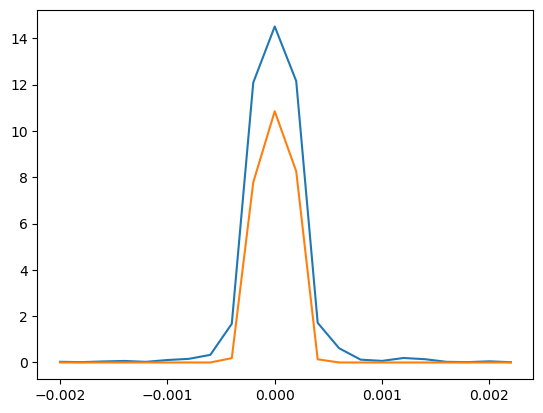

In [31]:
fig, ax = plt.subplots()
ax.plot(phi_values, rocking_maxvals)
ax.plot(phi_values, np.subtract(rocking_maxvals, rocking_ptpvals))
plt.show()